In [283]:
# Import dos módulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

---
## Leitura e pré-tratamento dos dados

In [284]:
# Lendo arquivo onde estão os dados oriundos do web scrapping
df_imoveis = pd.read_excel('imoveis_recife.xlsx')
df_imoveis.head()

,Titulo Imovel,Valor,Link,Localizacao,Bairro,Quartos,Banheiros,Área útil,Valor condomínio,Vagas garagem
0,Candeias Prince - 2102 B - Proprietário,R$ 690.000,https://pe.olx.com.br/grande-recife/imoveis/ca...,"Recife, Boa Viagem",Boa Viagem,3,2,67m²,NaN,1
1,Vende-se Flat em Muro Alto,R$ 510.000,https://pe.olx.com.br/grande-recife/imoveis/ve...,"Recife, Madalena",Madalena,1,1,34m²,R$ 645,5 ou mais
2,ILHA DE GHARBI - RUA DA HORA ESPINHEIRO. APTO....,R$ 550.000,https://pe.olx.com.br/grande-recife/imoveis/il...,"Recife, Espinheiro",Espinheiro,4,3,120m²,R$ 850,2
3,Apartamento Parque Prince,R$ 415.000,https://pe.olx.com.br/grande-recife/imoveis/ap...,"Recife, Cordeiro",Cordeiro,2,2,63m²,R$ 650,1
4,Imóvel para venda com 18 metros quadrados com ...,R$ 320.000,https://pe.olx.com.br/grande-recife/imoveis/im...,"Recife, Boa Viagem",Boa Viagem,1,1,18m²,R$ 250,1


O DataFrame (df) traz informações relevantes sobre os imóveis: título do imóvel, valor, localização e outras características (quartos, banheiros, área útil, etc.)

In [285]:
# Removendo os valores null
df_imoveis = df_imoveis.dropna()

In [286]:
# Verificando os valores únicos nas colunas categóricas
print('Unique garagens: ', df_imoveis['Vagas garagem'].unique())
print('Unique banheiros: ', df_imoveis['Banheiros'].unique())
print('Unique quartos: ', df_imoveis['Quartos'].unique())

Unique garagens:  ['5 ou mais' '2' '1' '0' '4' '3']
Unique banheiros:  ['1' '3' '2' '4' '5 ou mais']
Unique quartos:  ['1' '4' '2' '3' '5 ou mais']


Análise dos valores únicos nas colunas é importante para entender a diversidade das características dos imóveis. 
Valores como "5 ou mais" ou "nan" indica a necessidade de tratamento adicional para garantir a consistência dos dados, especialmente para análises estatísticas.

In [287]:
# Replace no valor '5 ou mais' para '5'- normalização para facilitar a análise quantitativa.
df_imoveis['Vagas garagem'] = df_imoveis['Vagas garagem'].replace('5 ou mais', '5')

df_imoveis['Banheiros'] = df_imoveis['Banheiros'].replace('5 ou mais', '5')

df_imoveis['Quartos'] = df_imoveis['Quartos'].replace('5 ou mais', '5')


In [288]:
# Removendo a unidade do valor na coluna e trazendo para o título - Área
df_imoveis.rename(columns={"Área útil": "Área útil (m2)"}, inplace=True)
df_imoveis["Área útil (m2)"] = df_imoveis["Área útil (m2)"].str.replace('m²', '').astype(int)

# Removendo a unidade do valor na coluna e trazendo para o título - Valor
df_imoveis.rename(columns={"Valor": "Valor (R$)"}, inplace=True)
df_imoveis["Valor (R$)"] = df_imoveis["Valor (R$)"].str.replace('R$', '').str.replace('.', '').str.strip().astype(float)

In [289]:
# Printar novas colunas
print(df_imoveis.columns)

Index(['Titulo Imovel', 'Valor (R$)', 'Link', 'Localizacao', 'Bairro',
       'Quartos', 'Banheiros', 'Área útil (m2)', 'Valor condomínio',
       'Vagas garagem'],
      dtype='object')


In [290]:
# Removendo as colunas que não são úteis na previsão
df_imoveis = df_imoveis.drop(['Titulo Imovel', 'Localizacao', 'Link', 'Valor condomínio'], axis = 1)

**Remoção de features irrelevantes** 

Titulo Imovel e link: Contém informações textuais que não contribuem diretamente para a previsão de valores.

Localizacao: É relevante, mas no cenário atual se equipara a ao campo 'Bairro'

Valor condomínio: o valor do condomínio pode não ser relevante para a previsão de preços de venda de imóveis, pois é muito variável e depende de informações sobre o condomínio, que não estão necessariamente contempladas no dataframe.

In [291]:
# Verificando a tipagem
df_imoveis.dtypes

Valor (R$)        float64
Bairro             object
Quartos            object
Banheiros          object
Área útil (m2)      int64
Vagas garagem      object
dtype: object

In [292]:
# Lista de colunas que precisam ser convertidas para numérico
colunas_para_converter = ['Quartos', 'Banheiros', 'Vagas garagem']

# Convertendo as colunas para numérico, substituindo valores inválidos por NaN
df_imoveis[colunas_para_converter] = df_imoveis[colunas_para_converter].apply(pd.to_numeric)

In [293]:
# Contando os valores vazios
valores_faltantes = df_imoveis.isnull().sum()
print(valores_faltantes)

Valor (R$)        0
Bairro            0
Quartos           0
Banheiros         0
Área útil (m2)    0
Vagas garagem     0
dtype: int64


Não há valores faltantes nas colunas relevantes, indicando que os dados estão completos para análise.

---
## Análise Exploratória de Dados

In [294]:
df_imoveis.describe()

,Valor (R$),Quartos,Banheiros,Área útil (m2),Vagas garagem
count,4.666000e+03,4666.000000,4666.000000,4666.000000,4666.00000
mean,8.091132e+05,2.661595,1.986498,116.504715,1.50943
std,1.983957e+06,0.934358,1.107719,1232.812437,0.77253
min,0.000000e+00,1.000000,1.000000,10.000000,0.00000
25%,3.800000e+05,2.000000,1.000000,52.000000,1.00000
50%,5.200000e+05,3.000000,2.000000,71.000000,1.00000
75%,8.900000e+05,3.000000,3.000000,118.000000,2.00000
max,1.257643e+08,5.000000,5.000000,73000.000000,5.00000


- Valor (R$): Grande variação, com média de ~R$ 809.000, mas com um valor máximo extremamente alto, sugerindo alguns imóveis muito caros.
- Quartos e Banheiros: A maioria dos imóveis tem 2 a 3 quartos e banheiros, com pouca variação.
- Área útil (m²): Média de 116 m², mas com valores extremos que vão até 73.000 m², indicando alguns imóveis muito grandes.
- Vagas garagem: Predominância de 1 a 2 vagas, com a maioria dos imóveis tendo 1 vaga.

Os dados mostram boa cobertura, mas existem valores extremos em preço e área útil, que devem ser observados com cautela.

In [295]:
# Substituir os valores (Valor (R$)) iguais a 0 por NaN e limpar - não faz sentido ter valores de imóvel = 0 e em seguida, limpar estes valores.
df_imoveis.replace({'Valor (R$)': 0}, np.nan, inplace=True)
df_imoveis.dropna(subset=['Valor (R$)'], inplace=True)

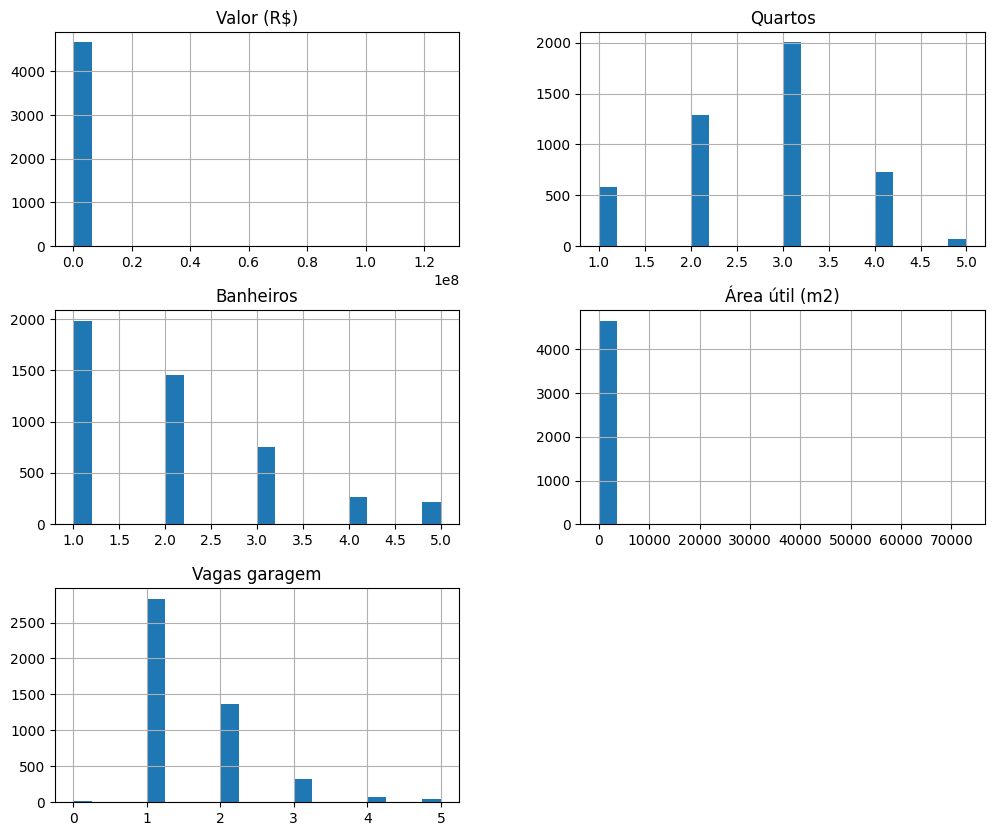

In [296]:
# Visualizando distribuições
df_imoveis.hist(bins=20, figsize=(12, 10))
plt.show()


- Valor: Apresenta grande concentração de imóveis no primeiro segmento... possívelmente há outliers.
- Quartos: mais concentrada entre 3 e 2 quartos, as demais ocorrências são menos comuns
- Banheiros: similar a distribuição de quartos, mas a maioria dos imóveis contém 1 ou 2 banheiros.
- Área útil: também há grande concentração no primeiro segmento, o que pode indicar presença de outliers.
- Vagas de garagem: há predominância entre 1 e 2 vagas por imóvel.

In [297]:
# Função para remover outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [298]:
# Calcular o IQR para 'Valor (R$)'
Q1_valor = df_imoveis['Valor (R$)'].quantile(0.25)
Q3_valor = df_imoveis['Valor (R$)'].quantile(0.75)
IQR_valor = Q3_valor - Q1_valor

# Definir limites para 'Valor (R$)'
lower_bound_valor = Q1_valor - 1.5 * IQR_valor
upper_bound_valor = Q3_valor + 1.5 * IQR_valor

# Identificar outliers em 'Valor (R$)'
outliers_valor = df_imoveis[(df_imoveis['Valor (R$)'] < lower_bound_valor) | (df_imoveis['Valor (R$)'] > upper_bound_valor)]

# Calcular o IQR para 'Área útil (m2)'
Q1_area = df_imoveis['Área útil (m2)'].quantile(0.25)
Q3_area = df_imoveis['Área útil (m2)'].quantile(0.75)
IQR_area = Q3_area - Q1_area

# Definir limites para 'Área útil (m2)'
lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area

# Identificar outliers em 'Área útil (m2)'
outliers_area = df_imoveis[(df_imoveis['Área útil (m2)'] < lower_bound_area) | (df_imoveis['Área útil (m2)'] > upper_bound_area)]

# Remover outliers de 'Valor (R$)'
df_imoveis = df_imoveis[(df_imoveis['Valor (R$)'] >= lower_bound_valor) & (df_imoveis['Valor (R$)'] <= upper_bound_valor)]

# Remover outliers de 'Área útil (m2)'
df_imoveis = df_imoveis[(df_imoveis['Área útil (m2)'] >= lower_bound_area) & (df_imoveis['Área útil (m2)'] <= upper_bound_area)]


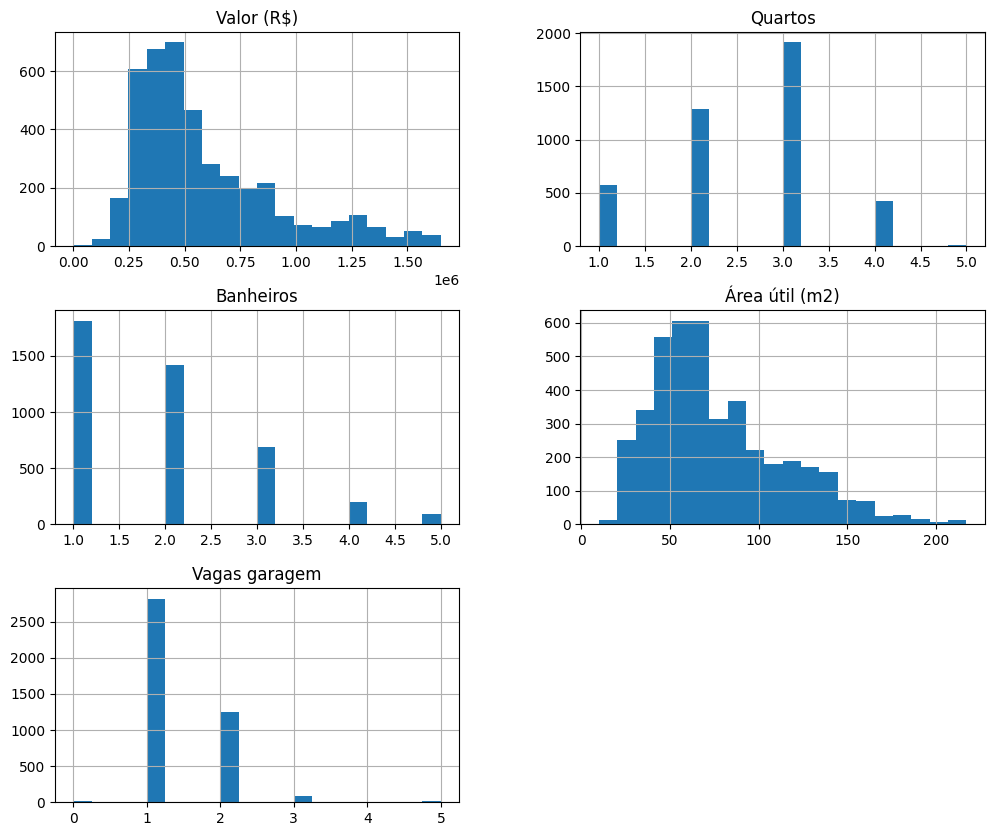

In [299]:
# Visualizando distribuições após tratar outliers
df_imoveis.hist(bins=20, figsize=(12, 10))
plt.show()

- Após a remoção dos outliers, a distribuição de valores ficou concentrada por volta dos R$600K, removendo os valoes extremamente altos observados anteriormente
- Para a área útil, a distribuição fica mais concentrada entre 50 e 100m², removendo também áreas muito elevadas vistas antes.

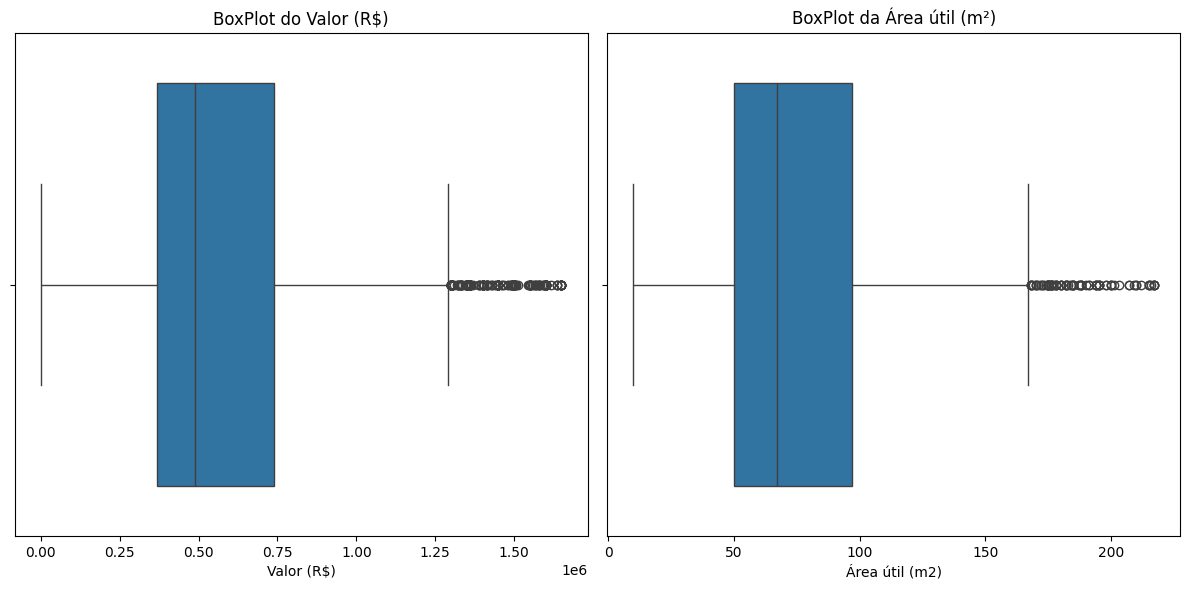

In [300]:
# Criar uma figura com 1 linha e 2 colunas para os gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# BoxPlot do Valor (R$)
sns.boxplot(ax=ax[0], data=df_imoveis, x='Valor (R$)')
ax[0].set_title('BoxPlot do Valor (R$)')

# BoxPlot da Área útil (m²)
sns.boxplot(ax=ax[1], data=df_imoveis, x='Área útil (m2)')
ax[1].set_title('BoxPlot da Área útil (m²)')

# Exibir os gráficos
plt.tight_layout()
plt.show()

In [301]:
# Contar as ocorrências por bairro
contagem_bairros = df_imoveis['Bairro'].value_counts()
contagem_bairros_df = contagem_bairros.reset_index()
contagem_bairros_df.columns = ['Bairro', 'Ocorrências']
print(contagem_bairros_df)

                 Bairro  Ocorrências
0            Boa Viagem         1564
1              Madalena          221
2          Casa Amarela          218
3          Encruzilhada          179
4           Imbiribeira          160
..                  ...          ...
58            Guabiraba            1
59  Córrego do Jenipapo            1
60        Vasco da Gama            1
61             Afogados            1
62        Ilha do Leite            1

[63 rows x 2 columns]


Existem no dataset alguns bairros com poucas amostras de imóveis. A remoção ou agrupamento desses bairros pode trazer algumas vantagens para a análise, como redução de ruído e melhora na performance do modelo.

In [302]:
# Filtrar os bairros que têm 10 ou mais imóveis
bairros_validos = contagem_bairros[contagem_bairros >= 10].index

# Substituir os bairros com menos de 10 imóveis por 'Outros'
df_imoveis['Bairro'] = df_imoveis['Bairro'].apply(lambda x: x if x in bairros_validos else 'Outros')

# Exibir a nova contagem
contagem_bairros = df_imoveis['Bairro'].value_counts()
print(contagem_bairros)


Bairro
Boa Viagem          1564
Madalena             221
Casa Amarela         218
Encruzilhada         179
Imbiribeira          160
Boa Vista            158
Pina                 151
Várzea               134
Tamarineira          131
Espinheiro           112
Torre                104
Rosarinho            102
Outros                95
Graças                89
Santo Amaro           82
Casa Forte            82
Cordeiro              71
Aflitos               61
Campo Grande          60
Torreão               58
Parnamirim            57
Caxangá               47
Ilha do Retiro        41
Poço                  37
Iputinga              36
Passarinho            27
Recife                23
Prado                 23
Zumbi                 20
Soledade              20
Monteiro              15
Jardim São Paulo      13
São José              13
Name: count, dtype: int64


In [303]:
# Resetando o índice e descartando o antigo - para reajustar a sequência numérica do DataFrame
df_imoveis = df_imoveis.reset_index(drop=True)

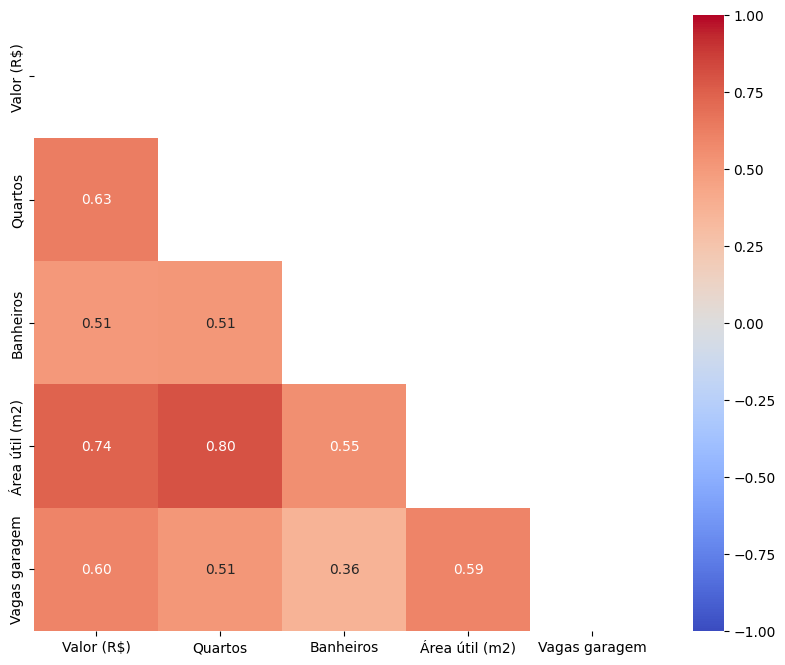

In [304]:
# Selecionar apenas colunas numéricas
df_numerico = df_imoveis.select_dtypes(include=[float, int])

# Calcular a matriz de correlação
corr_matrix = df_numerico.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, vmin=-1, vmax=1)
plt.show()

----

## Conversão em dummies + Divisão em treino/teste

In [305]:
# Convertendo a coluna "Bairro" em variáveis dummy (One-Hot Encoding) para que o modelo utilize

df_imoveis_dummies = pd.get_dummies(df_imoveis['Bairro'], prefix='Bairro', drop_first=True) # muito importante para evitar multicolinearidade perfeita

df_imoveis_dummies.head()


,Bairro_Boa Viagem,Bairro_Boa Vista,Bairro_Campo Grande,Bairro_Casa Amarela,Bairro_Casa Forte,Bairro_Caxangá,Bairro_Cordeiro,Bairro_Encruzilhada,Bairro_Espinheiro,Bairro_Graças,...,Bairro_Recife,Bairro_Rosarinho,Bairro_Santo Amaro,Bairro_Soledade,Bairro_São José,Bairro_Tamarineira,Bairro_Torre,Bairro_Torreão,Bairro_Várzea,Bairro_Zumbi
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [306]:
pd.Series({bairros: df_imoveis['Bairro'].unique() for bairros in df_imoveis})
contagem_distintos = df_imoveis['Bairro'].nunique()
print(f"Quantidade de categorias existentes na coluna bairros do df original: {contagem_distintos}")

num_colunas = df_imoveis_dummies.shape[1]
print(f"Quantidade de colunas resultante: {num_colunas}")

Quantidade de categorias existentes na coluna bairros do df original: 33
Quantidade de colunas resultante: 32


A análise acima é importante para evitar a dummy variable trap - que inclui todas as categorias convertidas como colunas no modelo. Essa trap acaba gera multicolinearidade, ou seja, uma relação linear entre as variáveis independentes, que pode distorcer os coeficientes do modelo e prejudicar a interpretação.

In [307]:
# Aplicando o Log na coluna de valor
df_imoveis['Valor (R$)'] = np.log(df_imoveis['Valor (R$)'])

Aplicar o logaritmo na coluna de valor é importante para normalizar a distribuição, especialmente diante da assimetria dos dados financeiros. Essa transformação ajuda a suavizar a influência de outliers, melhorando a performance do modelo de ML. Além disso, o logaritmo facilita a interpretação dos resultados em modelos de regressão.

In [308]:
# Selecionar variáveis numéricas
colunas_numericas = ['Área útil (m2)', 'Quartos', 'Banheiros', 'Vagas garagem', 'Valor (R$)']
df_numerico = df_imoveis[colunas_numericas]

# Concatenar variáveis dummy e numéricas
df_preparado = pd.concat([df_imoveis_dummies, df_numerico], axis=1)
df_preparado.reset_index(drop=True, inplace=True)
df_preparado.head()

,Bairro_Boa Viagem,Bairro_Boa Vista,Bairro_Campo Grande,Bairro_Casa Amarela,Bairro_Casa Forte,Bairro_Caxangá,Bairro_Cordeiro,Bairro_Encruzilhada,Bairro_Espinheiro,Bairro_Graças,...,Bairro_Tamarineira,Bairro_Torre,Bairro_Torreão,Bairro_Várzea,Bairro_Zumbi,Área útil (m2),Quartos,Banheiros,Vagas garagem,Valor (R$)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,34,1,1,5,13.142166
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,120,4,3,2,13.217674
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,63,2,2,1,12.936034
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,18,1,1,1,12.676076
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,49,2,1,1,12.765688


In [309]:
# Separando colunas numericas de boolean - para usar o scaler
numeric_cols = df_preparado.select_dtypes(include=['number'])

# Separando colunas dummies
not_numeric_cols = df_preparado.select_dtypes(exclude=['number'])

# Aplicando o escalonamento nas variáveis numéricas
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_cols)
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_cols.columns)

In [313]:
# Separando as targets
target = 'Valor (R$)'

X_numeric_scaled_df = numeric_scaled_df.drop(columns=[target])  # Features
y = numeric_scaled_df[target]                 # Target

In [280]:
# Unindo o DF com as numéricas e não numéricas
X_scaled_df = pd.concat([X_numeric_scaled_df, not_numeric_cols], axis = 1)

In [315]:
# Separando treino x teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

---
## Modelo

MSE:  0.22229867302722722
R²:  0.7594619890483649


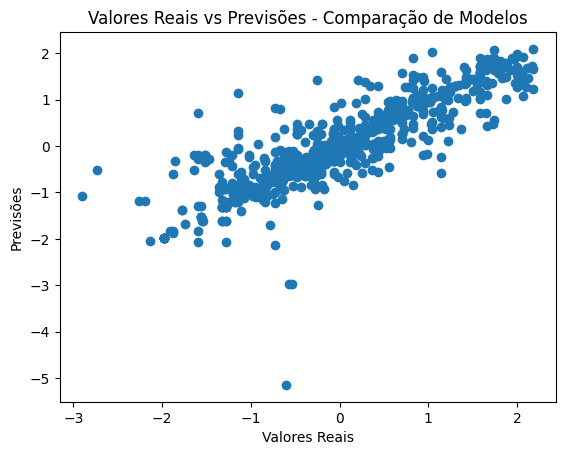

In [318]:
# Definir os modelos a serem testados
modelo = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
modelo.fit(X_train, y_train)
    
# Fazer previsões no conjunto de teste
y_pred = modelo.predict(X_test)
    
# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: ", mse)
print(f"R²: ", r2)

# Comparar previsões e valores reais
plt.scatter(y_test, y_pred)

plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Valores Reais vs Previsões - Comparação de Modelos')
plt.show()
